In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix


import lightgbm as lgb


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### Чтение и обзор данных

In [2]:
def read_data(path):
    df = pd.read_csv(path)
    print(f'Shape: {df.shape}')
    return df

In [3]:
train_df = read_data('data/train.csv')
train_df.head(3)

Shape: (595212, 59)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0


In [4]:
test_df = read_data('data/test.csv')
test_df.head(3)

Shape: (892816, 58)


,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [6]:
train_df.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Данные анонимизированы, но по названию можно понять, что колонки с постфиксом cat - категориальные, а с постфиксом bin - бинарные.

Проверим эту гипотезу.

### Категориальные признаки

In [7]:
category_features = train_df.filter(like='cat').columns.to_list()

train_df[category_features].nunique().sort_values()

ps_car_08_cat      2
ps_ind_04_cat      3
ps_car_02_cat      3
ps_car_03_cat      3
ps_car_05_cat      3
ps_car_07_cat      3
ps_car_10_cat      3
ps_ind_02_cat      5
ps_car_09_cat      6
ps_ind_05_cat      8
ps_car_04_cat     10
ps_car_01_cat     13
ps_car_06_cat     18
ps_car_11_cat    104
dtype: int64

In [8]:
for col in category_features:
    print(train_df[col].value_counts())

 1    431859
 2    123573
 3     28186
 4     11378
-1       216
Name: ps_ind_02_cat, dtype: int64
 0    346965
 1    248164
-1        83
Name: ps_ind_04_cat, dtype: int64
 0    528009
 6     20662
 4     18344
 1      8322
 3      8233
-1      5809
 2      4184
 5      1649
Name: ps_ind_05_cat, dtype: int64
 11    207573
 7     179247
 6      62393
 10     50087
 4      26174
 9      20323
 5      18142
 8      15093
 3       6658
 0       5904
 2       2144
 1       1367
-1        107
Name: ps_car_01_cat, dtype: int64
 1    493990
 0    101217
-1         5
Name: ps_car_02_cat, dtype: int64
-1    411231
 1    110709
 0     73272
Name: ps_car_03_cat, dtype: int64
0    496581
1     32115
2     23770
8     20598
9     19034
6      1560
3       640
5       545
4       230
7       139
Name: ps_car_04_cat, dtype: int64
-1    266551
 1    172667
 0    155994
Name: ps_car_05_cat, dtype: int64
11    131527
1     118386
0     110420
14     59253
10     33466
4      31136
15     21732
6      209

Похоже, что пропуски были, но их заменили на "-1". 

Возвращаем наны, чтобы потом проверить разные способы заполнения пропусков.

In [9]:
train_df.isna().sum(axis=0)

id                0
target            0
ps_ind_01         0
ps_ind_02_cat     0
ps_ind_03         0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14         0
ps_ind_15         0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01         0
ps_reg_02         0
ps_reg_03         0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_03_cat     0
ps_car_04_cat     0
ps_car_05_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        0
ps_calc_07        0
ps_calc_08        0
ps_calc_09        0
ps_calc_10        0
ps_calc_11        0


#### Сравнение основных статистик обучающей и тестовой выборок

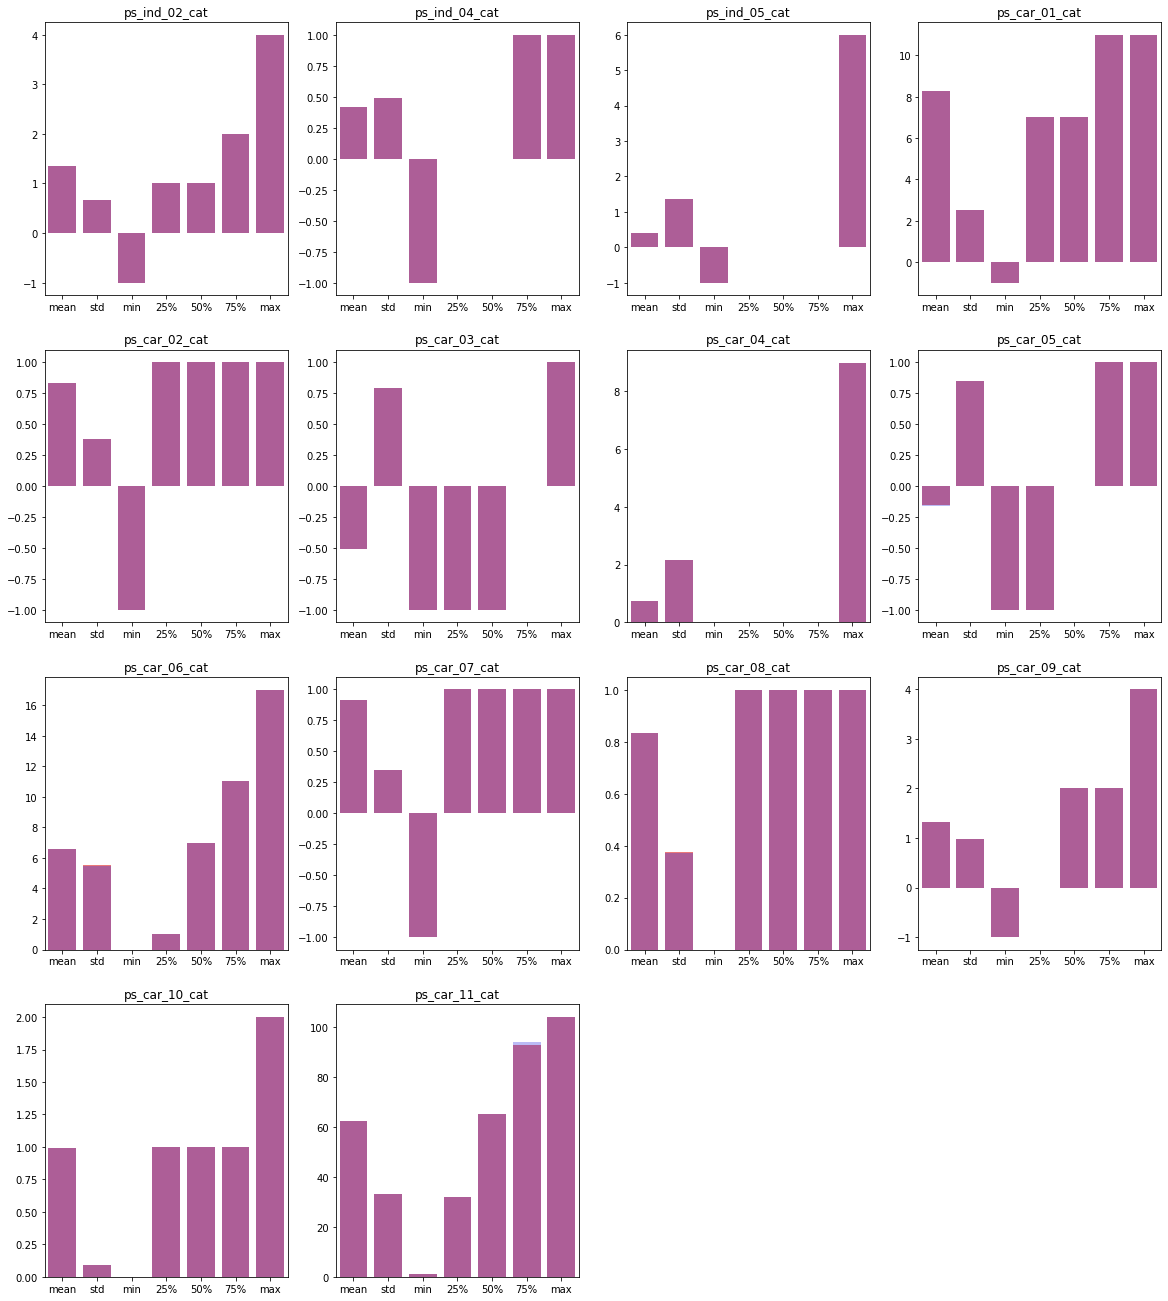

In [10]:
plt.figure(figsize=(20,300))

for num, feature in enumerate(category_features):
    plt.subplot(50,4,num+1)
    plt.title(feature)
    
    train_stat = train_df[feature].describe().drop('count', axis=0)
    test_stat = test_df[feature].describe().drop('count', axis=0)
    
    sns.barplot(x=train_stat.index, y=train_stat.values, alpha=0.6, color='r')
    sns.barplot(x=test_stat.index, y=test_stat.values, alpha=0.3, color='b')
    
plt.show()

Все признаки одинаково распределены в трейне и тесте. Это хорошо.

### Бинарные признаки

In [11]:
binary_features = train_df.filter(like='bin').columns.tolist()
train_df[binary_features].nunique().sort_values()

ps_ind_06_bin     2
ps_calc_18_bin    2
ps_calc_17_bin    2
ps_calc_16_bin    2
ps_calc_15_bin    2
ps_ind_18_bin     2
ps_ind_17_bin     2
ps_calc_19_bin    2
ps_ind_16_bin     2
ps_ind_12_bin     2
ps_ind_11_bin     2
ps_ind_10_bin     2
ps_ind_09_bin     2
ps_ind_08_bin     2
ps_ind_07_bin     2
ps_ind_13_bin     2
ps_calc_20_bin    2
dtype: int64

#### Сравнение основных статистик обучающей и тестовой выборок

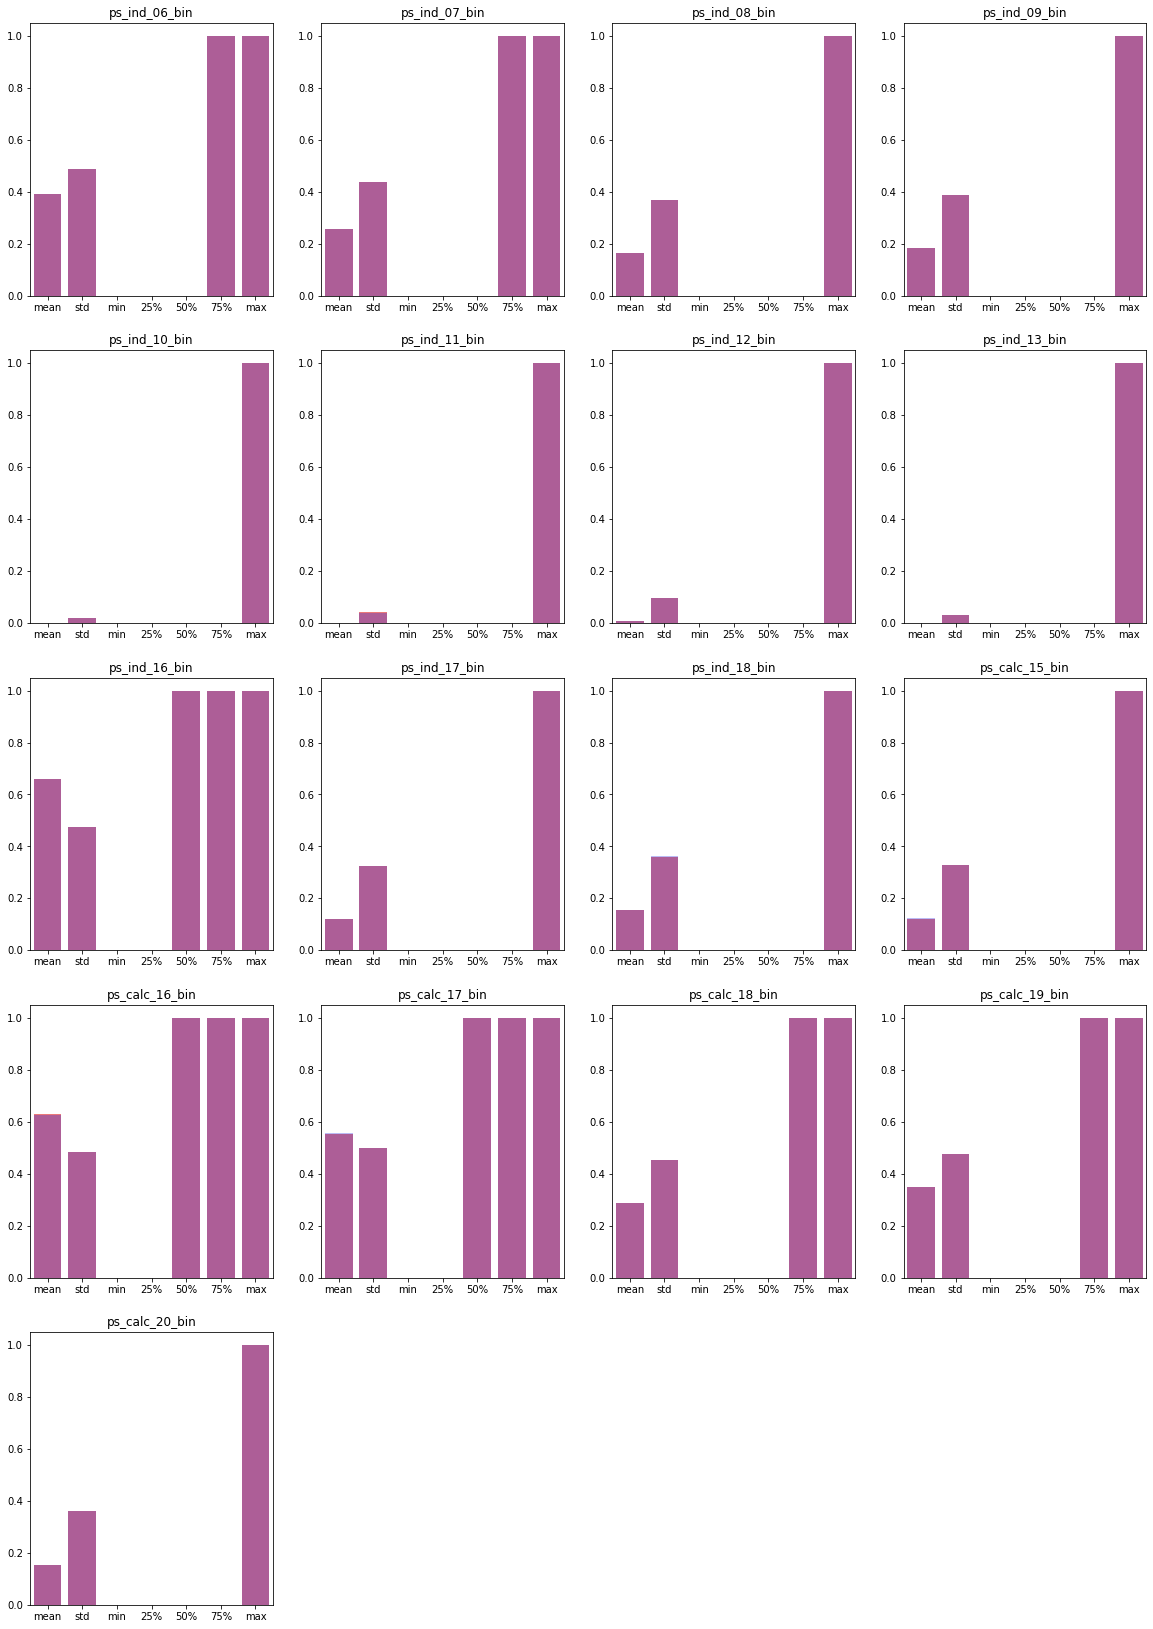

In [12]:
plt.figure(figsize=(20,300))

for num, feature in enumerate(binary_features):
    plt.subplot(50,4,num+1)
    plt.title(feature)
    
    train_stat = train_df[feature].describe().drop('count', axis=0)
    test_stat = test_df[feature].describe().drop('count', axis=0)
    
    sns.barplot(x=train_stat.index, y=train_stat.values, alpha=0.6, color='r')
    sns.barplot(x=test_stat.index, y=test_stat.values, alpha=0.3, color='b')
    
plt.show()

Бинарные признаки тоже одинаково распределены в трейне и тесте.

Для экономии ресурсов изменим тип данных у этих признаков.

#### Количественные признаки

In [13]:
numeric_features = [col for col in train_df.columns if col not in (
    train_df.filter(like='cat').columns.tolist() + train_df.filter(like='bin').columns.tolist() + ['id', 'target'])]

In [14]:
train_df[numeric_features].head(2)

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
0,2,5,0,11,0.7,0.2,0.718070,2,0.400000,0.883679,...,1,10,1,10,1,5,9,1,5,8
1,1,7,0,3,0.8,0.4,0.766078,3,0.316228,0.618817,...,1,9,5,8,1,7,3,1,1,9


In [15]:
train_df[numeric_features].nunique().sort_values()

ps_ind_14         5
ps_car_11         5
ps_calc_04        6
ps_calc_05        7
ps_ind_01         8
ps_calc_09        8
ps_calc_07       10
ps_calc_03       10
ps_calc_02       10
ps_calc_01       10
ps_reg_01        10
ps_calc_06       11
ps_calc_08       11
ps_calc_12       11
ps_ind_03        12
ps_calc_13       14
ps_ind_15        14
ps_car_15        15
ps_reg_02        19
ps_calc_11       20
ps_calc_14       24
ps_calc_10       26
ps_car_12       184
ps_car_14       850
ps_reg_03      5013
ps_car_13     70482
dtype: int64

Признаки, у которых количество уникальных значений меньше 50, очень похожи на категориальные, возможно, порядковые.

In [16]:
train_df.select_dtypes(include=['float']).head(2)

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
0,0.7,0.2,0.718070,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2
1,0.8,0.4,0.766078,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3


In [17]:
float_features = train_df.select_dtypes(include=['float']).columns.tolist()

#### Найдем дискретные признаки среди непрерывных.

In [18]:
round((
    len(train_df[float_features]) - train_df[float_features].count()) / 
    len(train_df[float_features]) * 100, 2).sort_values(ascending=False)

ps_calc_03    0.0
ps_calc_02    0.0
ps_calc_01    0.0
ps_car_15     0.0
ps_car_14     0.0
ps_car_13     0.0
ps_car_12     0.0
ps_reg_03     0.0
ps_reg_02     0.0
ps_reg_01     0.0
dtype: float64

In [19]:
discrete = [
    'ps_car_11',
    'ps_car_12',
    'ps_calc_02',
    'ps_car_13',
    'ps_car_02_cat',
    'ps_car_15',
    'ps_reg_02',
    'ps_reg_01',
    'ps_calc_01',
    'ps_calc_03'
]

### Распределение количественных признаков

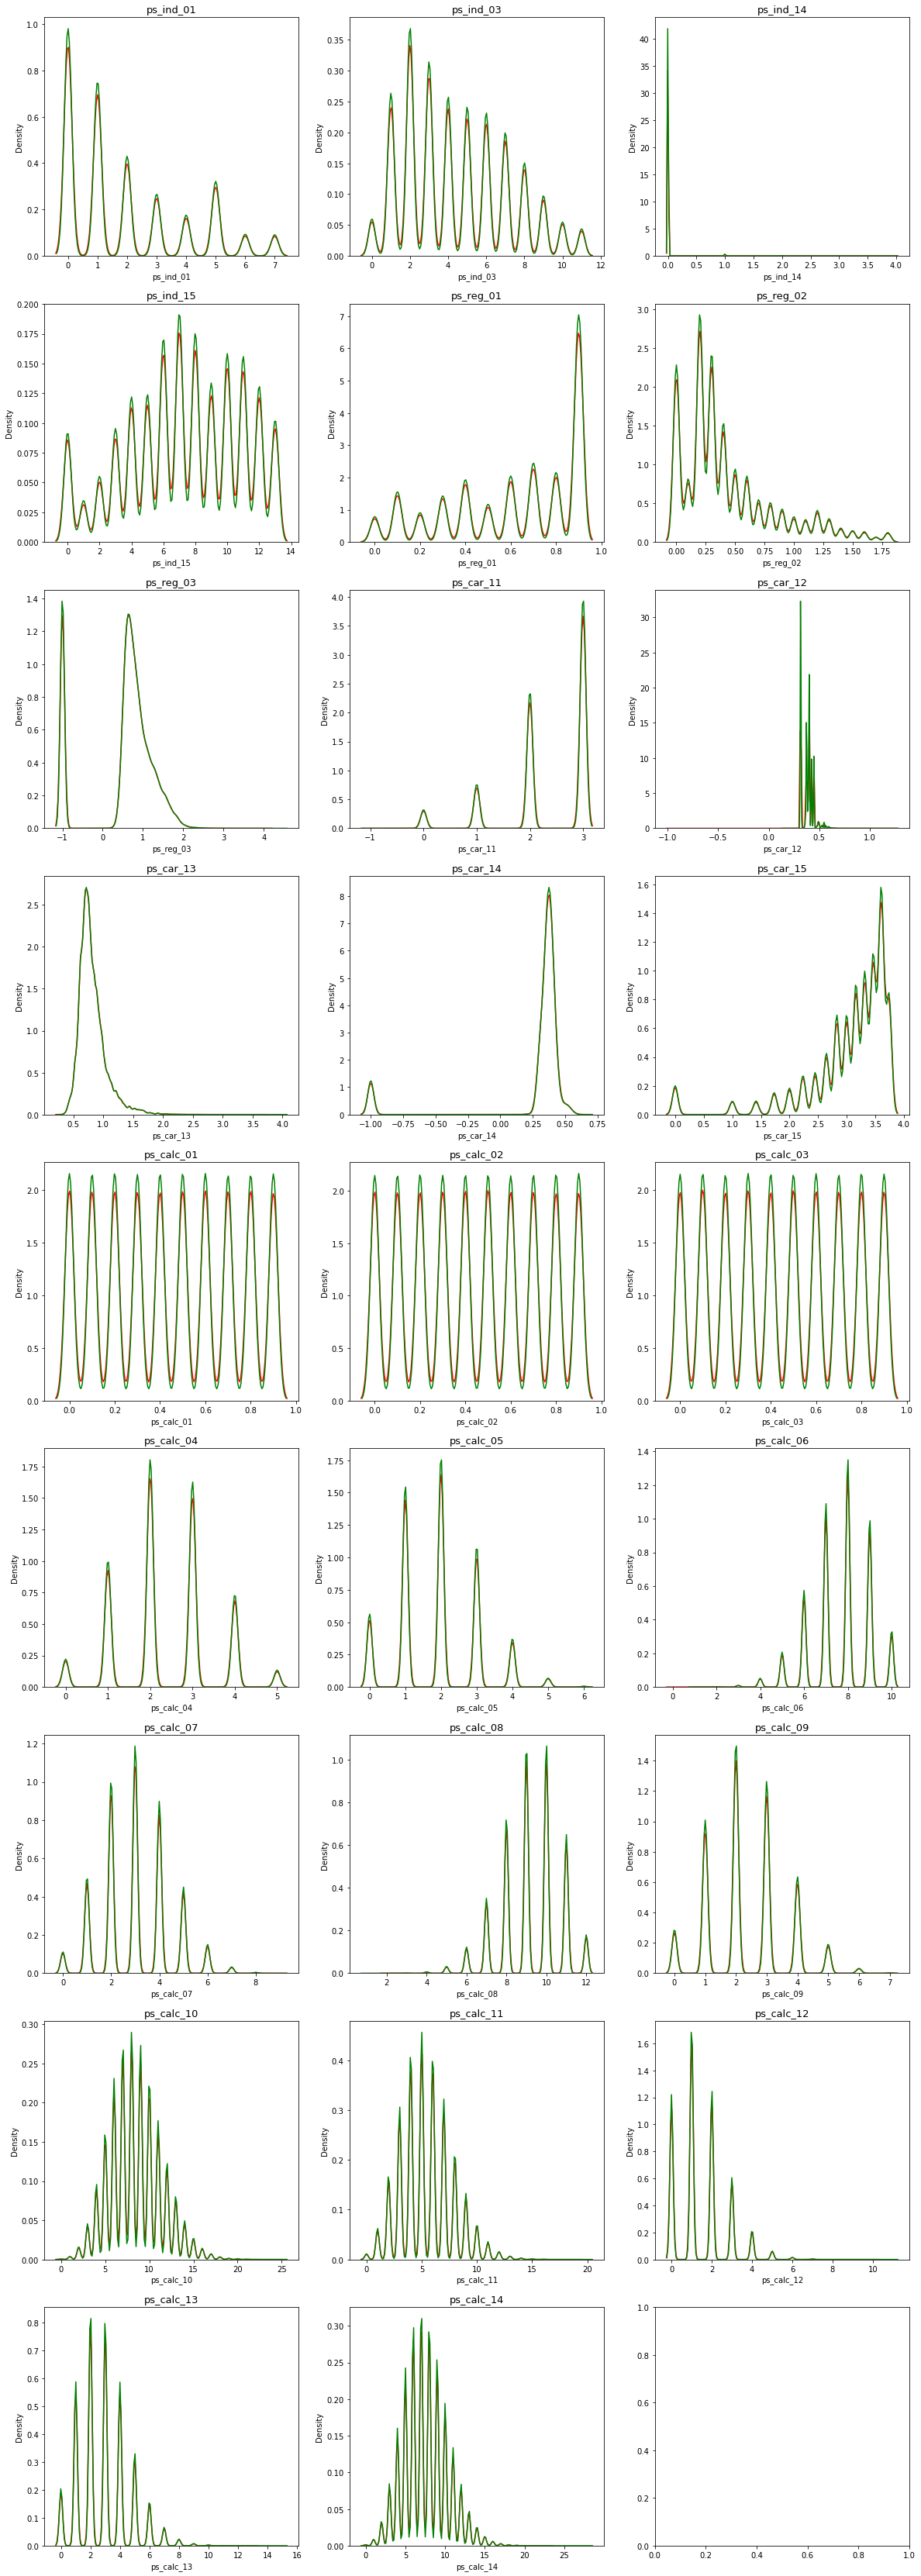

In [20]:
fig, axes = plt.subplots(9, 3, figsize=(20, 60))

for num, feature in enumerate(numeric_features):
    sns.kdeplot(train_df[feature], ax=axes[num//3, num%3], color="red", label="train")
    sns.kdeplot(test_df[feature], ax=axes[num//3, num%3], color="green", label="test")
    axes[num//3, num%3].set_title(feature, fontsize=13)
plt.show()

Только 4 признака похожи на неприрывную величину, остальные имеют дискретное распределение.

Плотности распределения признаков на трейне и тесте не совпадают. 

### Целевая переменная

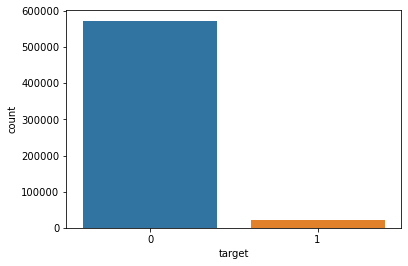

In [21]:
target = "target"
sns.countplot(x=train_df[target]);

In [22]:
round(train_df.loc[train_df['target'] == 1].shape[0] / train_df.shape[0], 2)

0.04

## Зависимость распределения признаков от целевой переменной

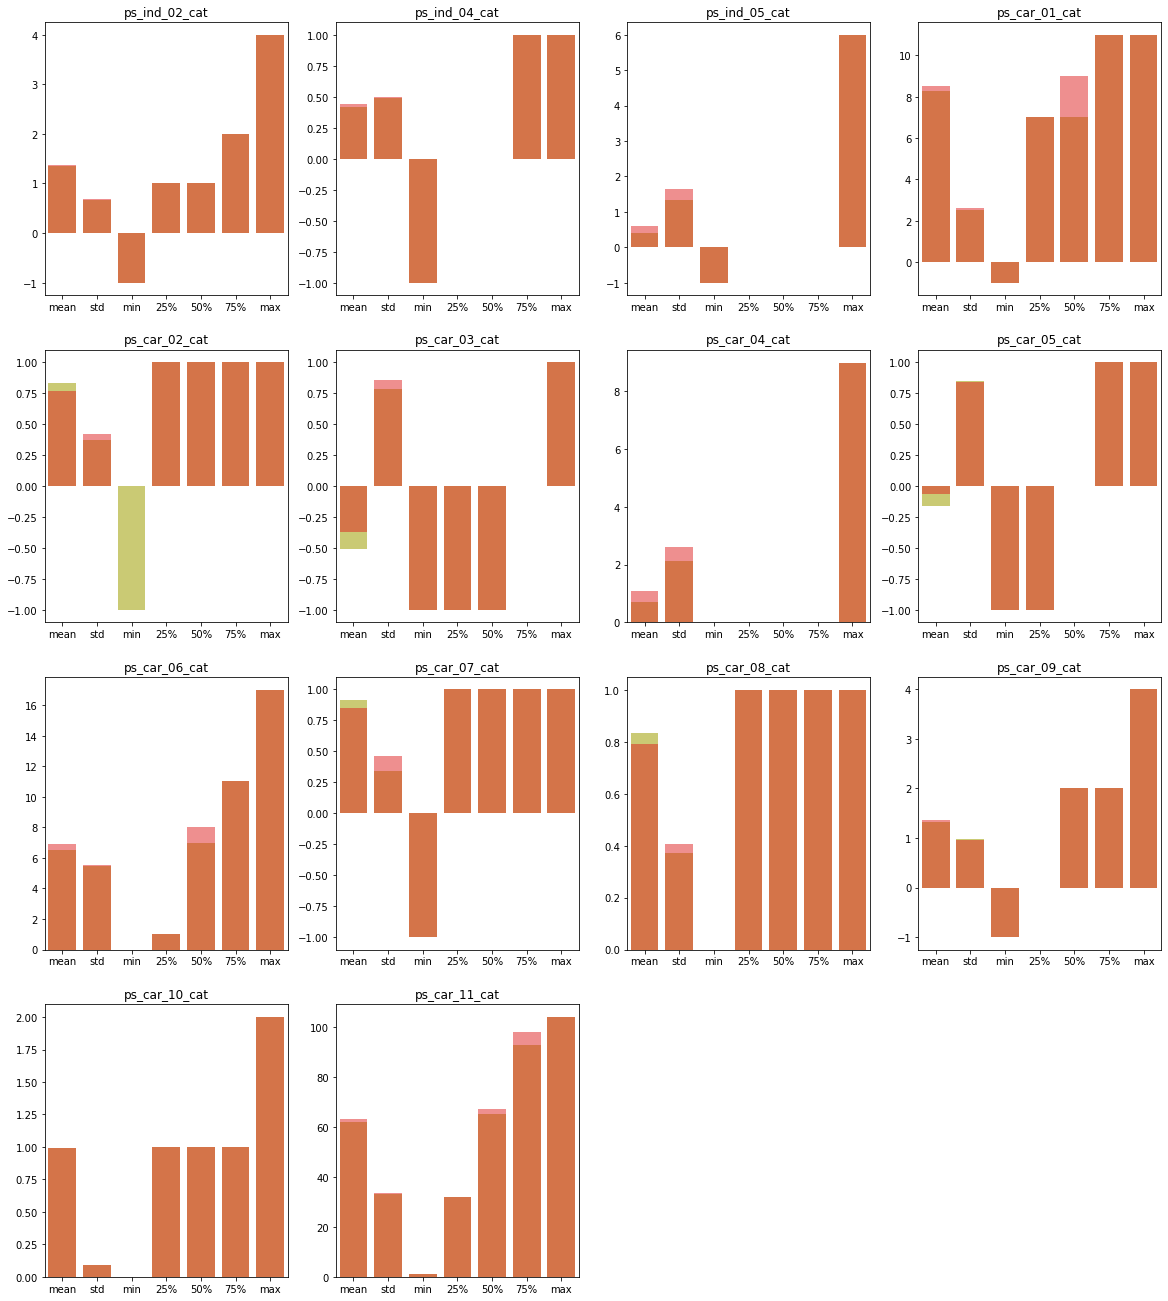

In [23]:
plt.figure(figsize=(20,300))

for num, feature in enumerate(category_features):
    plt.subplot(50,4,num+1)
    plt.title(feature)
    
    train_df_stat_t0 = train_df.loc[train_df[target] == 0, feature].describe().drop('count', axis=0)
    train_df_stat_t1 = train_df.loc[train_df[target] == 1, feature].describe().drop('count', axis=0)
    
    sns.barplot(x=train_df_stat_t0.index, y=train_df_stat_t0.values, alpha=0.6, color='y')
    sns.barplot(x=train_df_stat_t1.index, y=train_df_stat_t1.values, alpha=0.5, color='r')
    
plt.show()

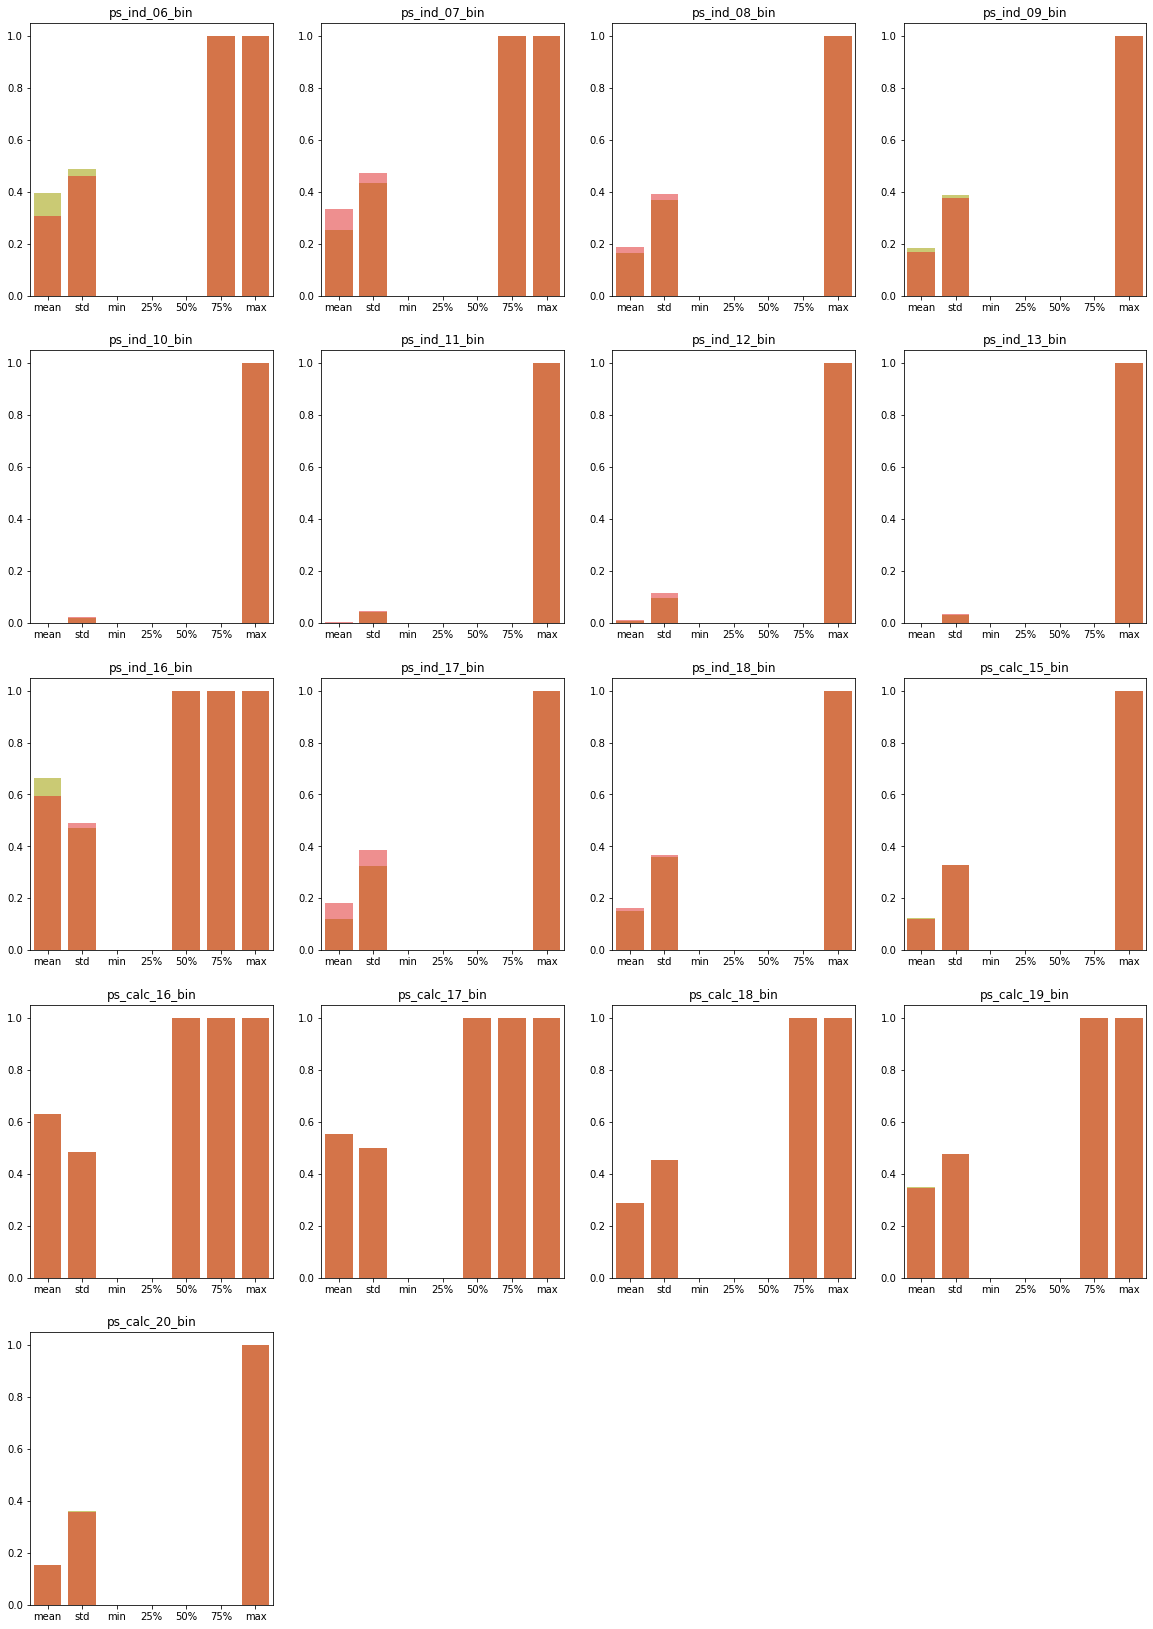

In [24]:
plt.figure(figsize=(20, 300))

for num, feature in enumerate(binary_features):
    plt.subplot(50, 4, num+1)
    plt.title(feature)
    
    train_df_stat_t0 = train_df.loc[train_df[target] == 0, feature].describe().drop('count', axis=0)
    train_df_stat_t1 = train_df.loc[train_df[target] == 1, feature].describe().drop('count', axis=0)
    
    sns.barplot(x=train_df_stat_t0.index, y=train_df_stat_t0.values, alpha=0.6, color='y')
    sns.barplot(x=train_df_stat_t1.index, y=train_df_stat_t1.values, alpha=0.5, color='r')
    
plt.show()

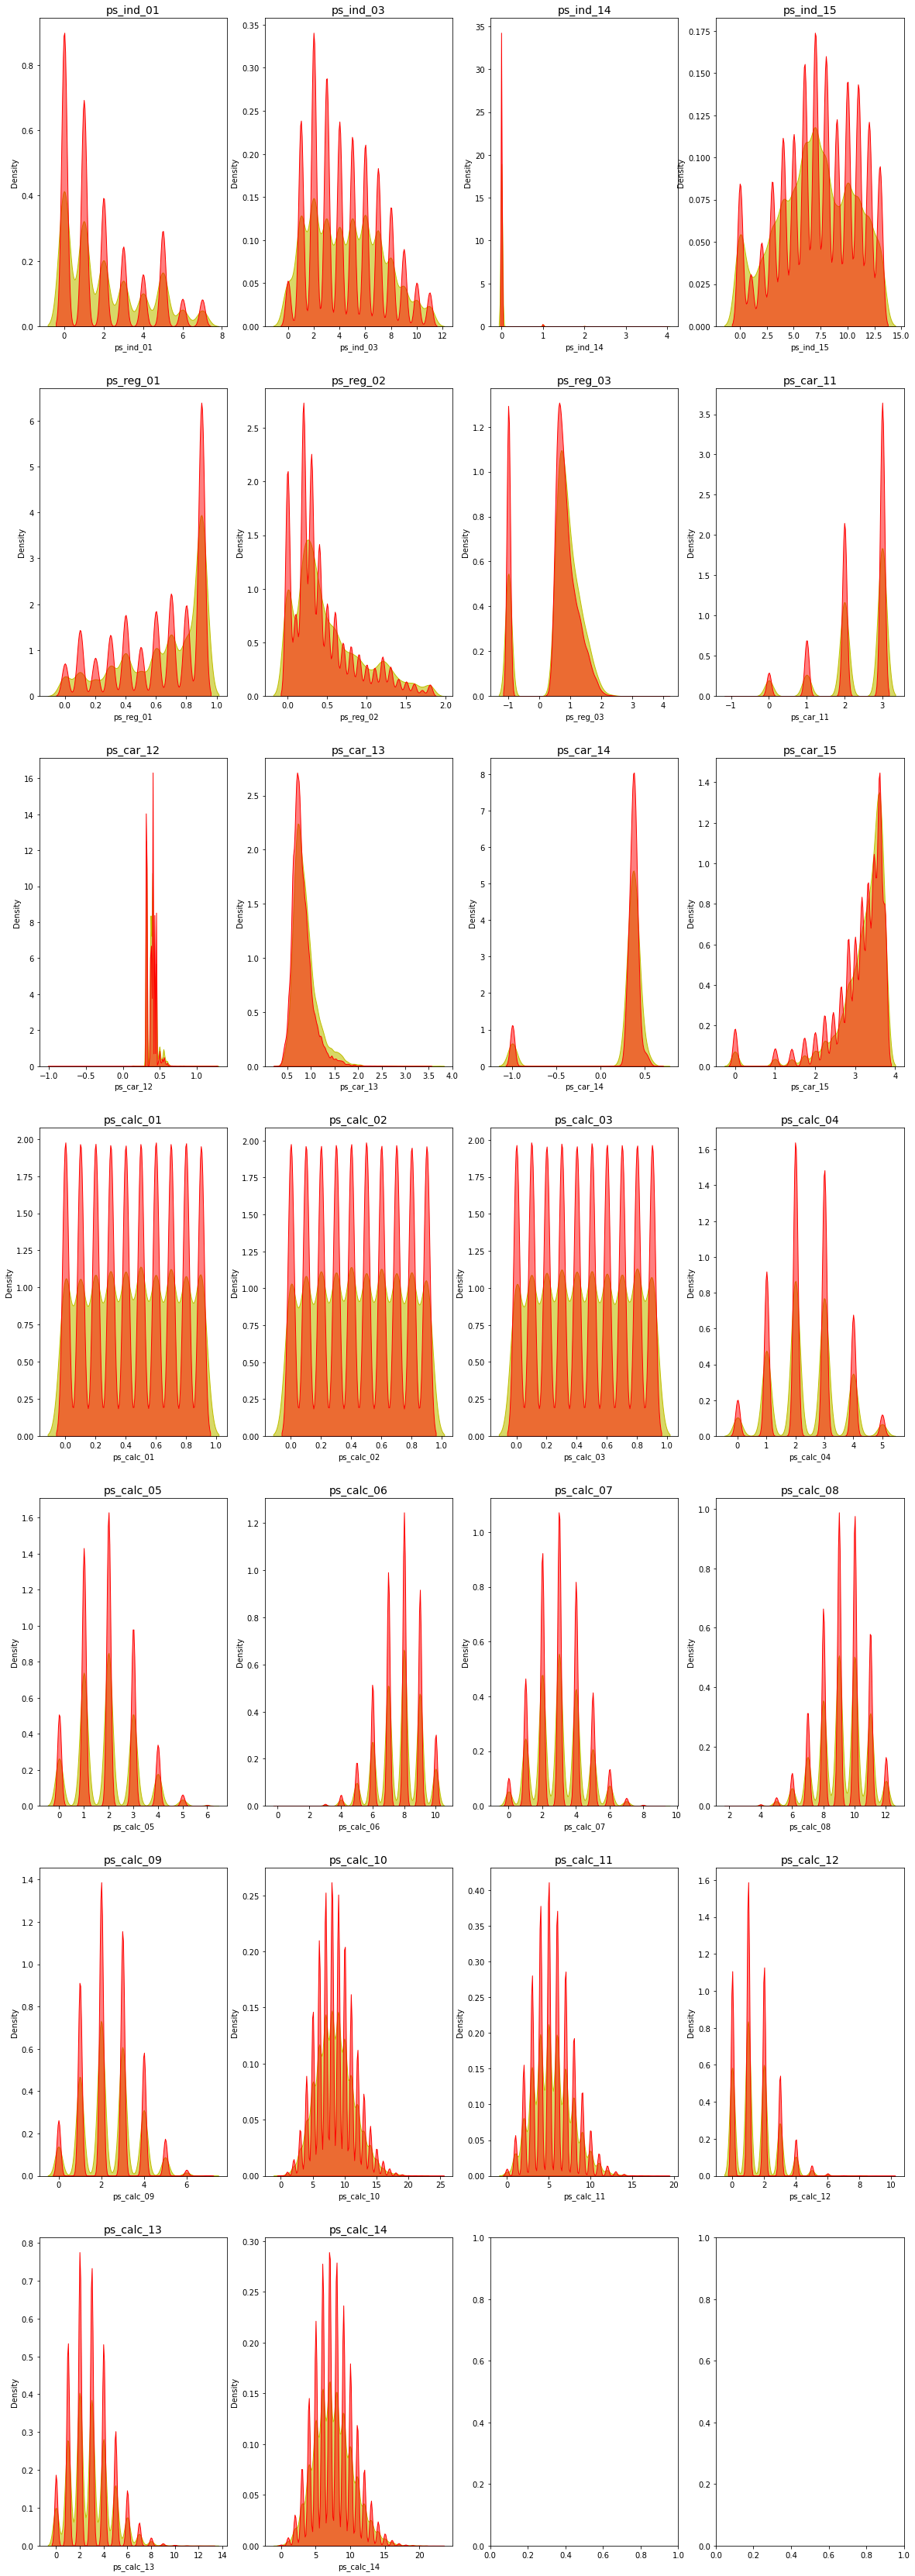

In [25]:
fig, axes = plt.subplots(7, 4, figsize=(20, 60))

for num, feature in enumerate(numeric_features):
    try:
        sns.kdeplot(train_df.loc[train_df[target] == 1, feature], ax=axes[num//4, num%4], 
                    shade=True, alpha=0.6, legend=False, color='y')
        sns.kdeplot(train_df.loc[train_df[target] == 0, feature], ax=axes[num//4, num%4], 
                    shade=True, alpha=0.5, legend=False, color='r')
    except RuntimeError:
        pass
    axes[num//4, num%4].set_title(feature, fontsize=14)
plt.show()

In [26]:
train_df.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


### Обработка пизнаков

In [27]:
def preprocessing(df, binary_features, discrete):
    df[binary_features] = df[binary_features].astype(np.uint8)
    df[discrete] = df[discrete].astype(np.int32)
    df = df.mask(train_df < 0)
    return df


train_df = preprocessing(train_df, binary_features, discrete)
test_df = preprocessing(test_df, binary_features, discrete)

### Балансировка целевой переменной

In [28]:
def balance_df_by_target(df, target):
    '''Return balanced on Target dataset'''
    
    target_counts = df[target].value_counts()

    major_class_name = target_counts.values.argmax()
    minor_class_name = target_counts.values.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / 
                           target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target] == minor_class_name].sample(
                                target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

### Бейзлайн

In [29]:
X_train, X_test = train_test_split(
    train_df.drop(columns=['id']),
    test_size=0.25,
    random_state=27
)

X_train = balance_df_by_target(X_train, 'target')
y_train = X_train.pop('target')

y_test = X_test.pop('target')

baseline = lgb.LGBMClassifier()
baseline.fit(X_train, y_train, 
             eval_set=[(X_test, y_test)], 
             categorical_feature=category_features, 
             eval_metric='auc', 
             verbose=False)

preds = baseline.predict_proba(X_test, num_iteration=baseline.best_iteration_)
roc_auc_score(y_test, preds[:, 1])

0.6172317906382927

In [30]:
preds = baseline.predict(X_test, num_iteration=baseline.best_iteration_)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.70      0.81    143336
           1       0.06      0.46      0.10      5467

    accuracy                           0.69    148803
   macro avg       0.51      0.58      0.46    148803
weighted avg       0.94      0.69      0.79    148803



In [31]:
confusion_matrix(y_test, preds)

array([[100379,  42957],
       [  2936,   2531]], dtype=int64)

In [32]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

In [33]:
gini_normalized(y_test, preds)

0.1570429696864817

## PipeLine